In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import altair as alt

# Load and cleanup data

We load user activity data and cloud cost data for the duration of the semester
into pandas dataframes. We make sure our timezones are right, and that we fill in
NaNs where we have missing data.

In [2]:
semester_start = pd.Timestamp('2018-08-15').tz_localize('US/Pacific')
semester_end = pd.Timestamp('2018-12-15').tz_localize('US/Pacific')

In [3]:
# Log data for user activity
path_usage = '../data/processed/fall-2018/user-activity.jsonl'
datahub = pd.read_json(path_usage, lines=True)

# Index by timestamp
datahub = datahub.set_index('timestamp')

# Our timestamps are in UTC
datahub = datahub.tz_localize('UTC')
# But we want them in US/Pacific, since that's how our billing data is setup
datahub = datahub.tz_convert('US/Pacific')
# Only between start and end of semester
datahub = datahub[datahub.index > semester_start][datahub.index < semester_end]

In [4]:
# Cost per day, in PST
cost = pd.read_json('../data/processed/fall-2018/cloud-costs.jsonl', lines=True)

cost = cost.set_index('start_time')
cost = cost.drop(columns=['end_time'])
# Pandas' read_json reads dates in as UTC, but since our *actual* dates for cloud costs are in PST, we convert back
cost = cost.tz_localize('UTC')
cost = cost.tz_convert('US/Pacific')

# Only between start and end of semester
cost = cost[cost.index > semester_start][cost.index < semester_end]
# We only use indexing timestamps to make the tz_localize easier.
# after that, we drop it to make everything else easier
cost = cost.reset_index()

# Fill in any missing data before beginning of date
missing_dates = pd.date_range(semester_start, cost.start_time.min(), name='start_time')
missing_dates_cost = pd.DataFrame(missing_dates, np.full(len(missing_dates), np.nan), columns={'start_time', 'cost'})
cost = cost.append(missing_dates_cost)

# Metrics

We munge our raw data into specific metrics we care about

## Daily Active user

We count someone as a 'daily active user' if they start / stop their notebook server
at least once. Due to anonimization techniques applied earlier, this might slightly
under count users

In [5]:
# Unique daily users - we count anyone who has logged in at least once a day
# We want a dataframe with no index so we can use it easily with Altair
daily_active_users = pd.DataFrame(datahub['user'].resample('D').nunique()).reset_index()

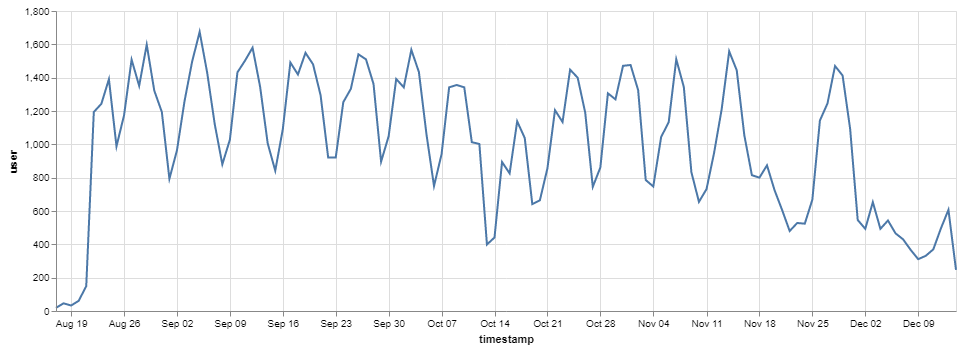

In [6]:
alt.Chart(daily_active_users, width=900).mark_line().encode(
    x='timestamp',
    y='user'
)

## Daily cloud costs

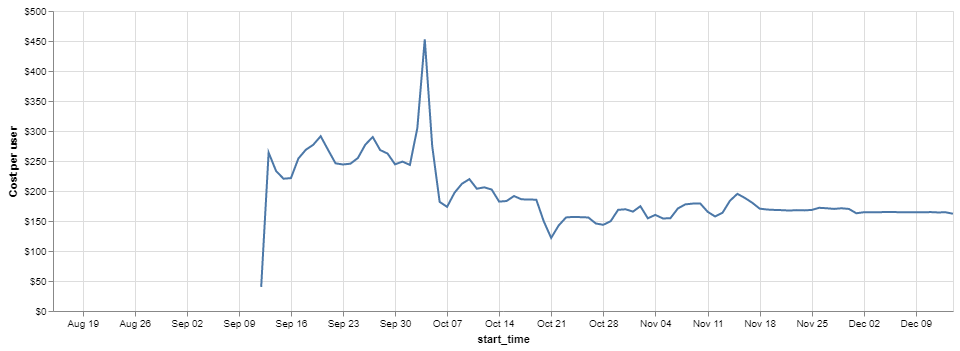

In [27]:
alt.Chart(cost, width=900).mark_line().encode(
    x='start_time',
    y=alt.Y('cost', axis=alt.Axis(format="$.0f", title="Cost per user"))
)

## Daily cloud costs per **active** user

This is cost per day for *active* users - those who used the cluster. This is only a fraction of your total users, so be careful using this for estimates.

In [8]:
# Combine into a single dataframe based on day
total = pd.merge(daily_active_users, cost, how='outer', left_on='timestamp', right_on='start_time').drop(columns=['start_time'])

# Calculate daily cost per user
total['cost_per_user'] = total['cost'] / total['user']

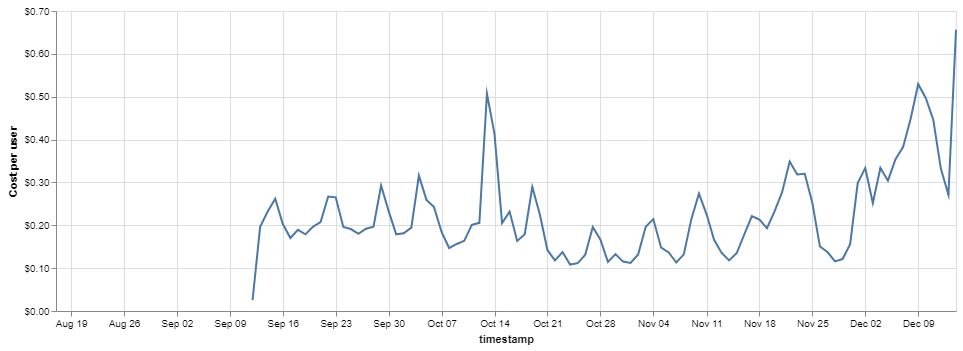

In [22]:
alt.Chart(total, width=900).mark_line().encode(
    x='timestamp',
    y=alt.Y('cost_per_user', axis=alt.Axis(format="$.2f", title="Cost per user"))
)